https://colab.research.google.com/drive/1na1yVhBF9MYPntbr6bfGd6qwWKl-uJGS?usp=sharing#scrollTo=p4ZFLYEkUlO9

https://colab.research.google.com/drive/1EEDH099GalrgqNbEaDgPm-OCHULBQ3HT?usp=sharing#scrollTo=LZxXK6g_b-Uq

https://github.com/nguyenkhoa0209/pinns_tutorial/tree/main


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from math import *
import sys

import scipy
from scipy import io

import torch
import torch.nn as nn
import torch.optim as optim

cmap = plt.get_cmap('inferno')
cmap2 = plt.get_cmap('seismic')

In [2]:
# Define the domain

nx = 256                     # spatial resolution
nt = 100                     # temporal resolution
x = np.linspace(-1, 1, nx)   # spatial grid
t = np.linspace(0, 1, nt)    # temporal grid
X, T = np.meshgrid(x,t)      # 2D grid for the domain

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None])) # X_star contains all (x, t) coordinate pairs as rows, with shape (nx * nt, 2).
print(X_star.shape)

(25600, 2)


In [3]:
# Load the data
u_star_array = np.load('burgers_sol.npy', allow_pickle=True) 
u_star = u_star_array[20]

In [4]:
# Load the data
u_star_array = np.load('burgers_sol.npy', allow_pickle=True) 
u_star = u_star_array[20]

# Define training points
N_data = 1000
idx_Xdata = np.random.choice(X_star.shape[0], N_data, replace=False)  # Randomly select N_data points from X_star
X_data = X_star[idx_Xdata]
u_data = u_star[idx_Xdata].squeeze()

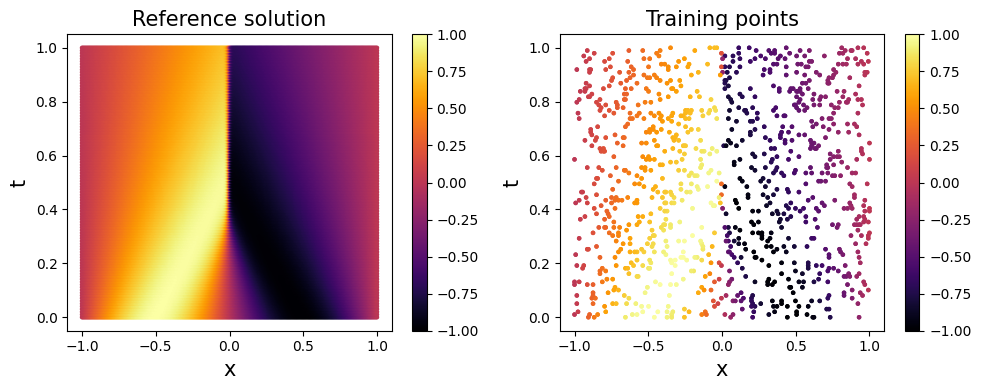

In [5]:
fig = plt.figure(figsize=[10,4])
(ax1, ax2) = fig.subplots(1,2, sharex=False, sharey=False)

img1 = ax1.scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap=cmap, vmax=1, vmin=-1, s=5)
ax1.set_title('Reference solution', fontsize=15)
ax1.set_xlabel('x', fontsize=15)
ax1.set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=ax1)

img2 = ax2.scatter(X_data[:, 0:1], X_data[:, 1:2], c=u_data, cmap=cmap, vmax=1, vmin=-1, s=5)
ax2.scatter(X_data[:, 0:1], X_data[:, 1:2], c=u_data, cmap=cmap, vmax=1, vmin=-1, s=5)
ax2.set_title('Training points', fontsize=15)
ax2.set_xlabel('x', fontsize=15)
ax2.set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=ax2)
plt.tight_layout()
plt.show()

In [6]:
# Prepare data
X_data_tensor = torch.tensor(X_data, dtype=torch.float32)
u_data_tensor = torch.tensor(u_data, dtype=torch.float32).unsqueeze(-1)
X_star_tensor = torch.tensor(X_star, dtype=torch.float32)
u_star_tensor = torch.tensor(u_star, dtype=torch.float32)

In [7]:
# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, layers):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = torch.tanh

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))
        x = self.layers[-1](x)  # No activation for the last layer
        return x


In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, layers):
        super(NeuralNetwork, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            layer = nn.Linear(layers[i], layers[i+1])
            nn.init.xavier_normal_(layer.weight)  # Xavier initialization
            nn.init.zeros_(layer.bias)  # Zero bias
            self.layers.append(layer)

        self.activation = torch.tanh

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))
        x = self.layers[-1](x)  # No activation for the last layer
        return x

In [9]:
# Define the architecture
layers = [2] + [50] * 4 + [1]

model = NeuralNetwork(layers)

# Set optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

epochs = 1000

from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X_data_tensor, u_data_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for epoch in range(epochs):
    for batch_X, batch_y in loader:
        model.train()
        optimizer.zero_grad()
        u_pred = model(batch_X)
        loss = criterion(u_pred, batch_y)
        loss.backward()
        optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.3153015077114105
Epoch 100, Loss: 0.013498522341251373
Epoch 200, Loss: 0.047985561192035675
Epoch 300, Loss: 0.01214222889393568
Epoch 400, Loss: 0.0006163609796203673
Epoch 500, Loss: 0.004558799788355827
Epoch 600, Loss: 0.0021323119290173054
Epoch 700, Loss: 0.00034136290196329355
Epoch 800, Loss: 0.001024502096697688
Epoch 900, Loss: 0.0009323123376816511


Training error by Neural Network: 0.039103
Testing error by Neural Network: 0.048314


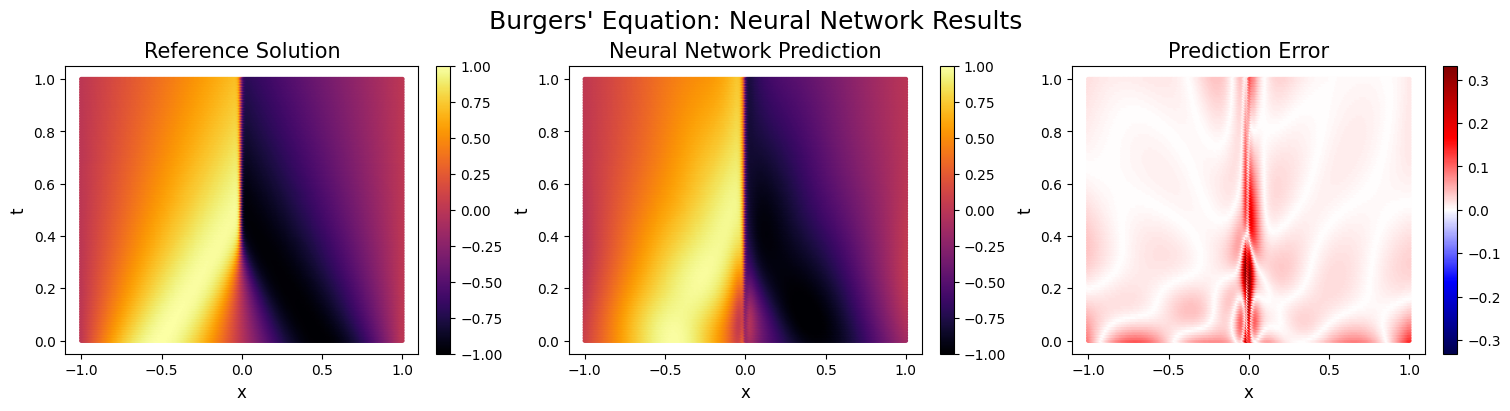

In [10]:

# Predictions
model.eval()
u_data_pred_NN = model(X_data_tensor).detach().numpy()
u_star_pred_NN = model(X_star_tensor).detach().numpy()

# Error calculations
training_error = np.linalg.norm(u_data_pred_NN.flatten() - u_data.flatten()) / np.linalg.norm(u_data.flatten())
testing_error = np.linalg.norm(u_star_pred_NN.flatten() - u_star.flatten()) / np.linalg.norm(u_star.flatten())
print(f"Training error by Neural Network: {training_error:.6f}")
print(f"Testing error by Neural Network: {testing_error:.6f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

# Reference solution
scatter_ref = axes[0].scatter(
    X_star[:, 0], X_star[:, 1], c=u_star, cmap=cmap, vmin=-1, vmax=1, s=5
)
axes[0].set_title('Reference Solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('t', fontsize=12)
plt.colorbar(scatter_ref, ax=axes[0])

# Neural network prediction
scatter_pred = axes[1].scatter(
    X_star[:, 0], X_star[:, 1], c=u_star_pred_NN.flatten(), cmap=cmap, vmin=-1, vmax=1, s=5
)
axes[1].set_title('Neural Network Prediction', fontsize=15)
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('t', fontsize=12)
plt.colorbar(scatter_pred, ax=axes[1])

# Error plot
c_lim = max(np.abs(u_star.flatten() - u_star_pred_NN.flatten()))
scatter_error = axes[2].scatter(
    X_star[:, 0], X_star[:, 1], c=np.abs(u_star.flatten() - u_star_pred_NN.flatten()), cmap=cmap2, vmin=-c_lim, vmax=c_lim, s=5
)
axes[2].set_title('Prediction Error', fontsize=15)
axes[2].set_xlabel('x', fontsize=12)
axes[2].set_ylabel('t', fontsize=12)
plt.colorbar(scatter_error, ax=axes[2])

plt.suptitle("Burgers' Equation: Neural Network Results", fontsize=18)
plt.show()

# PINN

In [11]:
# Define the domain

nx = 256
nt = 100
x = np.linspace(-1, 1, nx)
t = np.linspace(0, 1, nt)
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

In [12]:
# Define the IC
idx_init = np.where(X_star[:, 1]==0)[0]
X_init = X_star[idx_init]
u_init = -np.sin(pi*X_init[:, 0:1]).squeeze()

# Define the BC:
idx_bc = np.where((X_star[:, 0]==1.0)|(X_star[:, 0]==-1.0))[0]
X_bc = X_star[idx_bc]
u_bc = np.zeros((X_bc.shape[0], 1)).squeeze()

# Define training collocation points
N_f = 2000
idx_Xf = np.random.choice(X_star.shape[0], N_f, replace=False)
X_colloc_train = X_star[idx_Xf]

# Define the PDE parameter
nu = 0.025

Number of supervised points:  456
Number of collocation points:  2000


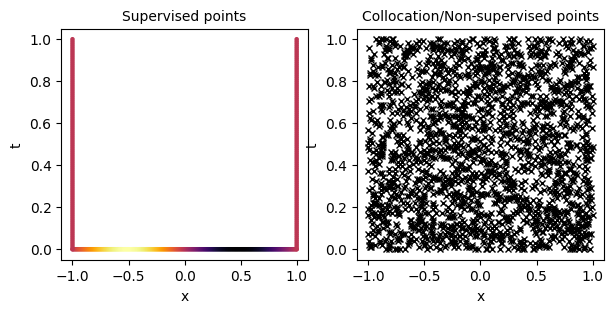

In [23]:
X_supervised = np.concatenate((X_init, X_bc), axis=0)
u_supervised = np.concatenate((u_init, u_bc), axis=0)

fig = plt.figure(figsize=[7,3])
axes = fig.subplots(1,2, sharex=False, sharey=False)
img1 = axes[0].scatter(X_supervised[:, 0:1], X_supervised[:, 1:2], c=u_supervised, cmap=cmap, vmax=1, vmin=-1, s=5)
axes[0].set_title('Supervised points', fontsize=10)
axes[0].set_xlabel('x', fontsize=10)
axes[0].set_ylabel('t', fontsize=10)
# plt.colorbar(img1, ax=axes[0])
img2 = axes[1].plot(X_colloc_train[:, 0], X_colloc_train[:, 1], 'x', markersize=5, color='black')
axes[1].set_title('Collocation/Non-supervised points', fontsize=10)
axes[1].set_xlabel('x', fontsize=10)
axes[1].set_ylabel('t', fontsize=10)

print("Number of supervised points: ", X_supervised.shape[0])
print("Number of collocation points: ", X_colloc_train.shape[0])

In [14]:
def net_transform(X_f, model_nn):
    """
    Apply the neural network to the input.

    Args:
        X_f (torch.Tensor): Input features.
        model_nn (torch.nn.Module): Neural network model.

    Returns:
        torch.Tensor: Network output.
    """
    return model_nn(X_f)

In [15]:
def f_user(X_f, model_nn, nu):
    """
    Define the PDE residual.

    Args:
        X_f (torch.Tensor): Input features (e.g., collocation points).
        model_nn (torch.nn.Module): Neural network model.
        nu (float): PDE parameter (e.g., viscosity in Burgers' equation).

    Returns:
        torch.Tensor: PDE residual.
    """
    x_temp = X_f[:, 0:1]
    t_temp = X_f[:, 1:2]

    # Enable gradient tracking
    x_temp.requires_grad_(True)
    t_temp.requires_grad_(True)

    # Concatenate inputs
    X_temp = torch.cat([x_temp, t_temp], dim=1)

    # Compute network output
    u = net_transform(X_temp, model_nn)

    # Compute derivatives using PyTorch autograd
    u_x = torch.autograd.grad(u, x_temp, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_temp, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t_temp, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Compute PDE residual
    f = u_t + u * u_x - nu * u_xx
    return f

In [16]:
def loss_f(f):
    """
    Compute the mean squared error of the PDE residual.

    Args:
        f (torch.Tensor): PDE residuals.

    Returns:
        torch.Tensor: Mean squared error of the residuals.
    """
    return torch.mean(f ** 2)

In [17]:
# Depth and width of the neural networks
layers = [2] + [50]*4 + [1]

# Learning rate for Adam optimizer
lr = 0.001

In [18]:
import sys
sys.path.append('../')  # Ensure the module path is accessible

# Reload the updated module
import importlib
import pinns  # Import the module
importlib.reload(pinns)

# Import the updated PINNs class
from pinns import PINNs

In [19]:
# Convert data to PyTorch tensors
X_colloc_train_tensor = torch.tensor(X_colloc_train, dtype=torch.float64)
X_bc_tensor = torch.tensor(X_bc, dtype=torch.float64)
u_bc_tensor = torch.tensor(u_bc, dtype=torch.float64).view(-1, 1)
X_init_tensor = torch.tensor(X_init, dtype=torch.float64)
u_init_tensor = torch.tensor(u_init, dtype=torch.float64).view(-1, 1)

In [20]:
# Instantiate the model
model_classic = PINNs(
    X_colloc_train_tensor,
    net_transform,
    lambda X, model: f_user(X, model, nu),  # Pass `nu` to `f_user`
    loss_f,
    layers,
    lr,
    type_problem='forward',
    X_bc=X_bc_tensor,
    u_bc=u_bc_tensor,
    X_init=X_init_tensor,
    u_init=u_init_tensor,
)

model_classic.net_u = model_classic.net_u.double()

# Train the model
model_classic.train(max_epochs_adam=0, max_epochs_lbfgs=2000, print_per_epochs=100)

/Users/sophiawilson/Documents/MScThesis/BurgerEQ/pinns.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_bc = torch.tensor(X_bc, dtype=torch.float64)
/Users/sophiawilson/Documents/MScThesis/BurgerEQ/pinns.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u_bc = torch.tensor(u_bc, dtype=torch.float64)
/Users/sophiawilson/Documents/MScThesis/BurgerEQ/pinns.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_init = torch.tensor(X_init, dtype=torch.float64)
/Users/sophiawilson/Documents/MScThesis/BurgerEQ/pinns.py:32

No data inside the domain
No other condition is provided
No data for testing
Loss at epoch 0 (L-BFGS): 0.4208339600146116
Loss at epoch 100 (L-BFGS): 0.049160762353118975
Loss at epoch 200 (L-BFGS): 0.005360672208821228
Loss at epoch 300 (L-BFGS): 0.0009033725362203759
Loss at epoch 400 (L-BFGS): 0.00035032720860553914
Loss at epoch 500 (L-BFGS): 0.00015134100669976912
Loss at epoch 600 (L-BFGS): 8.625194508963335e-05
Loss at epoch 700 (L-BFGS): 5.108427400017823e-05
Loss at epoch 800 (L-BFGS): 3.307211386348209e-05
Loss at epoch 900 (L-BFGS): 2.4777064279671287e-05
Loss at epoch 1000 (L-BFGS): 1.947745056464148e-05
Loss at epoch 1100 (L-BFGS): 1.6198400065094398e-05
Loss at epoch 1200 (L-BFGS): 1.3223100311813564e-05
Loss at epoch 1300 (L-BFGS): 1.0551626300126359e-05
Loss at epoch 1400 (L-BFGS): 7.849360082967965e-06
Loss at epoch 1500 (L-BFGS): 6.5983955543453505e-06
Loss at epoch 1600 (L-BFGS): 5.538312415305718e-06
Loss at epoch 1700 (L-BFGS): 4.720503524534522e-06
Loss at epoch 1

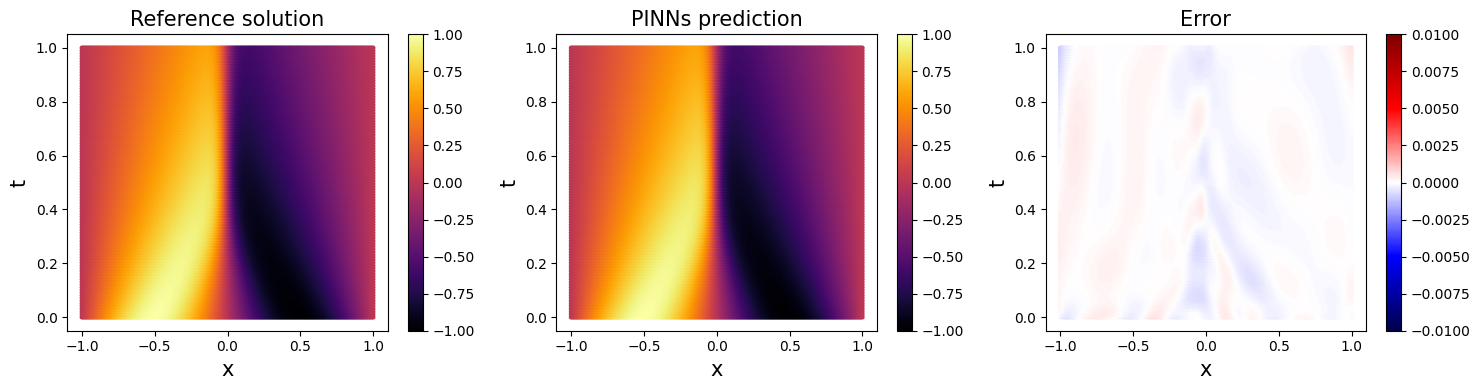

In [22]:
# Convert X_star to a PyTorch tensor
X_star_tensor = torch.tensor(X_star, dtype=torch.float64)

# Get the predictions from the model
with torch.no_grad():  # Disable gradient computation for inference
    pred = model_classic.net_transform(X_star_tensor, model_classic.net_u).numpy()

# Load the reference solution
u_star_array = np.load('burgers_sol.npy', allow_pickle=True)
u_star = u_star_array[-1]

# Plot the results
fig = plt.figure(figsize=[15, 4])
axes = fig.subplots(1, 3, sharex=False, sharey=False)

# Reference solution
img1 = axes[0].scatter(
    X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap=cmap, vmax=1, vmin=-1, s=5
)
axes[0].set_title('Reference solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=axes[0])

# PINNs prediction
img2 = axes[1].scatter(
    X_star[:, 0:1], X_star[:, 1:2], c=pred, cmap=cmap, vmax=1, vmin=-1, s=5
)
axes[1].set_title('PINNs prediction', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=axes[1])

# Error
error = u_star - pred
img3 = axes[2].scatter(
    X_star[:, 0:1], X_star[:, 1:2], c=error, cmap='seismic', vmax=0.01, vmin=-0.01, s=5
)
axes[2].set_title('Error', fontsize=15)
axes[2].set_xlabel('x', fontsize=15)
axes[2].set_ylabel('t', fontsize=15)
plt.colorbar(img3, ax=axes[2])

plt.tight_layout()
plt.show()